<a href="https://colab.research.google.com/github/olinyoder2534/TensorflowPractice/blob/main/BertTesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade tensorflow-hub==0.12.0
!pip install --upgrade tensorflow-text==2.9.0

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [2]:
preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"

In [3]:
bertPreprocessModel = hub.KerasLayer(preprocess_url)

In [4]:
text = ["The salad was amazing", "The salad was okay", "The salad was bad"]

In [5]:
textPreprocessed = bertPreprocessModel(text)

In [6]:
bertModel = hub.KerasLayer(encoder_url)

In [7]:
results = bertModel(textPreprocessed)

In [8]:
results.keys()

dict_keys(['pooled_output', 'encoder_outputs', 'sequence_output', 'default'])

In [9]:
import pandas as pd

In [10]:
spam = pd.read_csv('/content/spam.csv')

In [11]:
spam.shape

(5572, 2)

In [12]:
spam.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [13]:
spam['Category'] = spam['Category'].map({'ham': 0, 'spam': 1})

In [14]:
spam.head()

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [15]:
print("Spam count:",spam['Category'].value_counts()[1])
print("Non-Spam count:",spam['Category'].value_counts()[0])

Spam count: 747
Non-Spam count: 4825


In [16]:
#Rebalancing using undersampling
from imblearn.under_sampling import RandomUnderSampler

In [17]:
rus = RandomUnderSampler(random_state=42)
df_balanced, y_resampled = rus.fit_resample(spam[['Message', 'Category']], spam['Category'])

df_balanced = pd.DataFrame(df_balanced, columns=['Message', 'Category'])
df_balanced.head()

,Message,Category
0,If i not meeting ü all rite then i'll go home ...,0
1,"I.ll always be there, even if its just in spir...",0
2,"Sorry that took so long, omw now",0
3,I thk 50 shd be ok he said plus minus 10.. Did...,0
4,Dunno i juz askin cos i got a card got 20% off...,0


In [18]:
df_balanced.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
0            747    725                             Sorry, I'll call later   
1            747    641  Please call our customer service representativ...   

               
         freq  
Category       
0           8  
1           4

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['Category'], stratify=df_balanced['Category'])

In [20]:
X_train.head()

52                               Oh did you charge camera
1167    Free entry in 2 a weekly comp for a chance to ...
1009    HMV BONUS SPECIAL 500 pounds of genuine HMV vo...
1479    http//tms. widelive.com/index. wml?id=820554ad...
834     You have an important customer service announc...
Name: Message, dtype: object

In [ ]:
#Using the BERT model

In [21]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [23]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "This is bad",
    "Are you going to the concert?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.9111331 , -0.2587162 ,  0.18861862, ...,  0.23924446,
        -0.59219915,  0.92819643],
       [-0.93838966, -0.38401818, -0.82807547, ..., -0.625523  ,
        -0.68186796,  0.946324  ]], dtype=float32)>

In [24]:
words = get_sentence_embeding([
    "banana",
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

In [25]:
words

<tf.Tensor: shape=(6, 768), dtype=float32, numpy=
array([[-0.7606919 , -0.14219381,  0.4960461 , ...,  0.42165333,
        -0.532214  ,  0.80312175],
       [-0.86023223, -0.21242939,  0.4915689 , ...,  0.3979803 ,
        -0.60506296,  0.8447167 ],
       [-0.7128864 , -0.15463923,  0.38401636, ...,  0.352787  ,
        -0.5099134 ,  0.73474115],
       [-0.8253345 , -0.3555054 , -0.5906963 , ..., -0.01613662,
        -0.6141756 ,  0.87230295],
       [-0.7504134 , -0.26812598, -0.26689604, ...,  0.02839445,
        -0.5938098 ,  0.79749876],
       [-0.78544384, -0.299497  ,  0.41027427, ...,  0.5222542 ,
        -0.4957355 ,  0.81507534]], dtype=float32)>

In [29]:
from sklearn.metrics.pairwise import cosine_similarity

#banana-grapes
print(cosine_similarity([words[0]],[words[1]]))

#jeff bezos - elon musk
print(cosine_similarity([words[3]],[words[4]]))

#banana - elon musk
print(cosine_similarity([words[0]],[words[4]]))

[[0.9911088]]
[[0.9872034]]
[[0.8933632]]


In [ ]:
#modeling

In [30]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [32]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5)

Epoch 1/5
35/35 [==============================] - 541s 15s/step - loss: 0.6062 - accuracy: 0.6920
Epoch 2/5
35/35 [==============================] - 560s 16s/step - loss: 0.4970 - accuracy: 0.8384
Epoch 3/5
35/35 [==============================] - 517s 15s/step - loss: 0.4332 - accuracy: 0.8589
Epoch 4/5
35/35 [==============================] - 510s 15s/step - loss: 0.3973 - accuracy: 0.8652
Epoch 5/5
35/35 [==============================] - 513s 15s/step - loss: 0.3636 - accuracy: 0.8795


In [33]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 173s 14s/step - loss: 0.3312 - accuracy: 0.8984


[0.3312106132507324, 0.8983957171440125]

In [36]:
predictions = model.predict(X_test)

12/12 [==============================] - 187s 15s/step


In [39]:
positiveCnt = 0
negativeCnt = 0

for pred in predictions:
  if pred >= .5:
    positiveCnt += 1
  else:
    negativeCnt += 1

In [40]:
print(positiveCnt)
print(negativeCnt)

191
183


In [50]:
predictions1 = predictions.copy()

for i, pred in enumerate(predictions1):
  if pred >= 0.5:
    predictions1[i] = 1
  else:
    predictions1[i] = 0

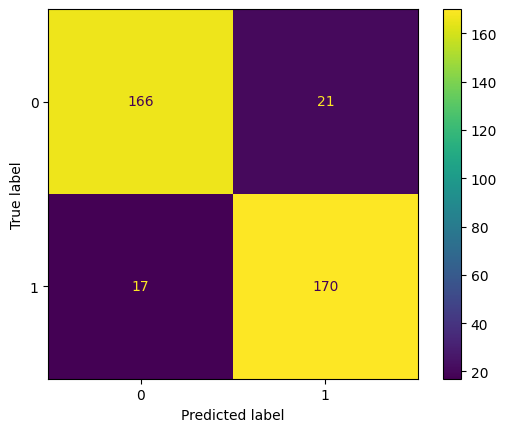

In [51]:
import matplotlib.pyplot as plt
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, predictions1)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

In [34]:
reviews = [
    'Congrats! You have been selected to help Okonkwo, the Nigerian Prince.',
    'See attached file',
    'You won $1000. Click the link below to enter your info to receive your reward.',
    'Hey man, are you coming for a game tomorrow',
    "Want to come over to watch a movie?"
]

model.predict(reviews)

1/1 [==============================] - 3s 3s/step


array([[0.67578393],
       [0.18064499],
       [0.6299994 ],
       [0.22602731],
       [0.09504282]], dtype=float32)

In [ ]:
#trying a different ml method

In [ ]:
#RAM crash
RFpreprocessed_text = bert_preprocess(X_train)
RFoutputs = bert_encoder(RFpreprocessed_text)